In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epidemy/dengue_labels_train.csv
/kaggle/input/epidemy/dengue_features_train.csv
/kaggle/input/epidemy/dengue_features_test.csv
/kaggle/input/epidemy/submission_format.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from platform import python_version
python_version()

'3.7.12'

In [3]:
# Some stuff from the Feature Engineering Course:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

Some relevant info from google: female mosquito lifetime is 42-56 days, male is 10
That is approximately 7 weeks for female mosquitos. So probably don't need to consider lags beyond that for weather features.

In [4]:
# This date parsing isn't doing anything, currently
# Note that while the features train contains dates for the beginning of each week, the labels data only 
# has the year, week information
dengue_features_train = pd.read_csv('../input/epidemy/dengue_features_train.csv',parse_dates=True,infer_datetime_format=True)
dengue_features_test = pd.read_csv('../input/epidemy/dengue_features_test.csv',parse_dates=True,infer_datetime_format=True)
dengue_labels_train   = pd.read_csv('../input/epidemy/dengue_labels_train.csv',parse_dates=True,infer_datetime_format=True)


Problem: the features have the start date of the week and the year and week, but the labels only have the week and year. 

In [5]:
for col in dengue_features_train.columns:
    print(col)

city
year
weekofyear
week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


In [6]:
dengue_features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [7]:
dengue_labels_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [8]:
from datetime import date, timedelta
import datetime
import math

debug_date_map=True

# store information on 
date_map_debug_logs=[]

set_of_bad_years=set()


# map from dataframe with year, weekofyear features
# to a time index
# lets go with weeks since day 1 of week 1 of 1990
def date_start_map(x):
    # isocalendar is in python 3.8 on, we have 3.7.12 here
    #date_start=date.fromisocalendar(1990, 1, 1)
    #date_current=date.fromisocalendar(x['year'],x['weekofyear'],1)
    # this format only works in 3.11 on
    #date_start=date.fromisoformat('1990-W01-1')
    #date_current=date.fromisoformat("%d-W%2d-1" % (x['year'],x['weekofyear']))
    year_one=1990
    week_one=1
    day_of_week=1
    # Trying thursday
    #day_of_week=4
#    date_one = datetime.datetime.strptime(f"{year_one}-W{week_one}-{day_of_week}","%Y-W%W-%w").date()
    date_one = datetime.datetime.strptime(f"{year_one}-U{week_one}-{day_of_week}","%Y-U%U-%w").date()

    year_current = x['year']
    week_current = x['weekofyear']

    # tools 
    # weekday: Return the day of the week as an integer, where Monday is 0 and Sunday is 6. The same as
    # isoweekday: Return the day of the week as an integer, where Monday is 1 and Sunday is 7. The same as
    # %j for 1-365 day
    # %U	Week number of year, Sunday as the first day of week, 00-53
    # %W	Week number of year, Monday as the first day of week, 00-53
       
    # trouble years are those where this data set incorrectly assigns a week at the 
    # beginning to the end. I've identified these as those starting with Friday, Saturday,
    # or Sunday
    raw_year_current = year_current
    raw_week_current = week_current
    trouble_year=False
    shift = 0
    year_start_date = datetime.datetime.strptime(f"{year_current}-M{1}-{1}","%Y-M%m-%d").date()

    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    if (year_start_date.weekday() >= 4):
        trouble_year=True
        set_of_bad_years.add(year_current)
        # need better check
        if (week_current >= 52):
            year_current-=1
            # trying to assign to Dec 31
            date_two = datetime.datetime.strptime(f"{year_current}-M{12}-{31}","%Y-M%m-%d").date()
        else:
            shift = 1
            date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()

      
    #    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    
    time_d = date_two - date_one
    weeks = math.ceil(time_d.days / 7.0)
    weeks += shift
    if debug_date_map:
        debug_log=f"{raw_year_current}-{raw_week_current} mapped to week {weeks} using days {time_d.days}"
        date_map_debug_logs.append(debug_log)
    
    return weeks



# issues so far:


In the csv:
sj,1994,50,149

sj,1994,51,112

sj,1995,52,154

sj,1995,1,91

sj,1995,2,72


sj,1995,49,23

sj,1995,50,17

sj,1995,51,17

sj,1996,1,23

sj,1996,2,14

sj,1996,3,20


It is clear that sj,1995,52,154 belongs in its order in the csv. Is this data recorded wrong? From ISO 8601, shouldn't 1995, 52 be 1994 52



In the features, which include the date of the beginning of the week

sj,1994,50,1994-12-17,

sj,1994,51,1994-12-24,

sj,1995,52,1995-01-01,

sj,1995,1,1995-01-08,

sj,1995,2,1995-01-15,

sj,1995,3,1995-01-22,

Disturbingly, the first days of the week are always reported as 01-01, 01-08, 01-015, etc, for each year.


Years I have identified with the issue:
1993,   1994,   1995,     1999,   2000,     2005,     2006, 

These years start with the following days of the week:
Friday, Saturday, Sunday, Friday, Saturday, Saturday, Sunday


Also of note, the off weeks are often like this:
sj,2005,53,2005-01-01,,,,,,,,,,,,,,,,,,,,
Missing all other data.

From the beginning of the week
sj,1993,53,1993-01-01,

sj,1994,52,1994-01-01,

sj,1995,52,1995-01-01,

sj,1999,53,1999-01-01,

sj,2000,52,2000-01-01,

sj,2005,53,2005-01-01,

sj,2006,52,2006-01-01,


Note that this  indicates that it treats Sunday as the first day of the week (non-ISO) for 1995. But then it changes for some of the other years

Can identify troublesome years by whether they begin with a Friday, Saturday, or Sunday

Two options, only one of which is accurate, I think: 
* for each of these cases, subtract the year by one so that it becomes the 52 or 53 week of the previous year.
* re-assign this to week 1, shift every week of the year forward by one




May be able to fix this with changing the date format from W to U or some similar thing.


With the latest fix: i'm missing a week :

2000-50 mapped to week 571 using days 3990

2000-51 mapped to week 572 using days 3997

2001-1 mapped to week 574 using days 4018

2001-2 mapped to week 575 using days 4025

In [9]:

dengue_labels_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [10]:
testrow1 = dengue_labels_train.loc[(dengue_labels_train['year']==1994) & (dengue_labels_train['weekofyear']==1)]
testrow2 = dengue_labels_train.loc[(dengue_labels_train['year']==1993) & (dengue_labels_train['weekofyear']==53)]

In [11]:
print(testrow1)
print(testrow2)

    city  year  weekofyear  total_cases
192   sj  1994           1           31
    city  year  weekofyear  total_cases
139   sj  1993          53           30


In [12]:
# clear log
date_map_debug_logs=[]

In [13]:

#startmap=lambda x: 52*(x['year']-1990) + x['weekofyear']
startmap=date_start_map

dengue_features_train['weeks_since_start']=dengue_features_train.apply(startmap,axis=1)
dengue_features_test['weeks_since_start']=dengue_features_test.apply(startmap,axis=1)
dengue_labels_train['weeks_since_start']=dengue_labels_train.apply(startmap,axis=1)


In [14]:
print(set_of_bad_years)
#for log in date_map_debug_logs:
#    print(log)


{1993, 1994, 1995, 1999, 2000, 2005, 2006, 2010, 2011, 2012}


Split into two cities for now. Could make use something like multiple output?

In [15]:

dengue_features_sj_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='sj'])
dengue_features_sj_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='sj'])
dengue_labels_sj_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='sj'])

dengue_features_iq_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='iq'])
dengue_features_iq_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='iq'])
dengue_labels_iq_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='iq'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [16]:
list_of_frames=[
    dengue_features_sj_train,
    dengue_features_sj_test,
    dengue_labels_sj_train,
    dengue_features_iq_train,
    dengue_features_iq_test,
    dengue_labels_iq_train
]
for frame in list_of_frames:
    frame.sort_values('weeks_since_start',inplace=True)
    frame.set_index('weeks_since_start',inplace=True)


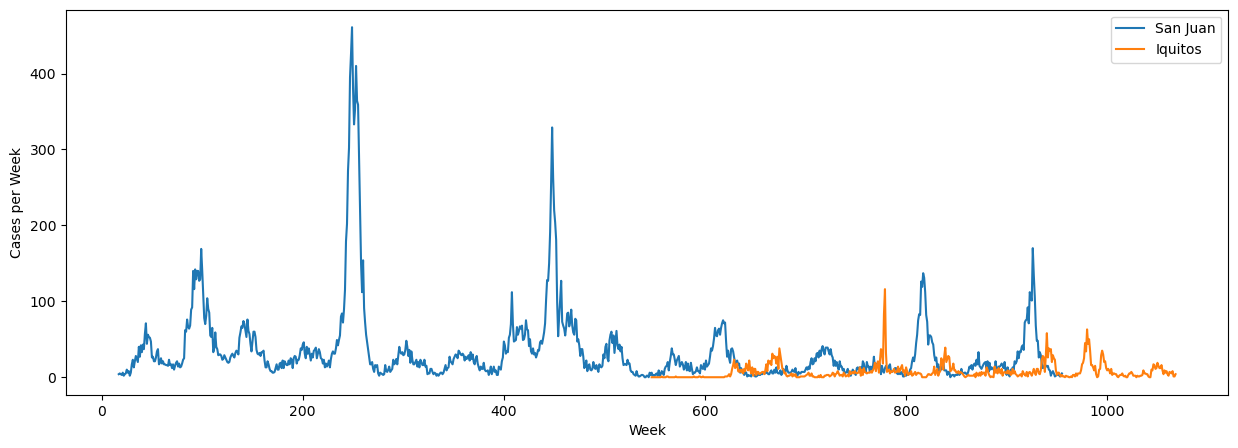

In [17]:
ax=dengue_labels_sj_train.loc[:,['total_cases']].plot(figsize=(15,5))
dengue_labels_iq_train.loc[:,['total_cases']].plot(ax=ax)
ax.legend(['San Juan','Iquitos'])
ax.set(xlabel="Week",ylabel="Cases per Week")
plt.savefig('test.png')

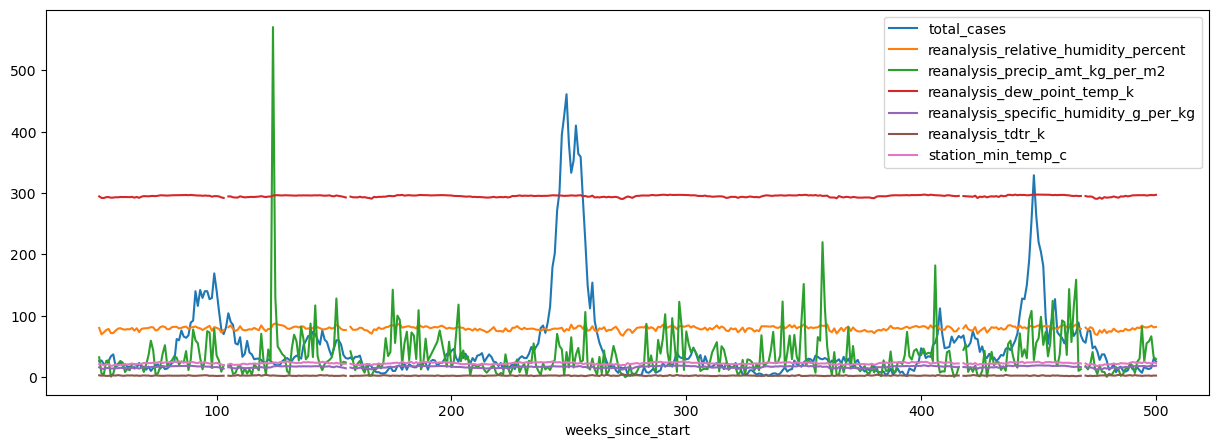

In [18]:
start_week=50
end_week=500

features_to_plot=['reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_tdtr_k',
                 'station_min_temp_c']
ax=dengue_labels_sj_train.loc[start_week:end_week,['total_cases']].plot(figsize=(15,5))
dengue_features_sj_train.loc[start_week:end_week,features_to_plot].plot(ax=ax)
plt.savefig('test_feature_cmp_sj.png')

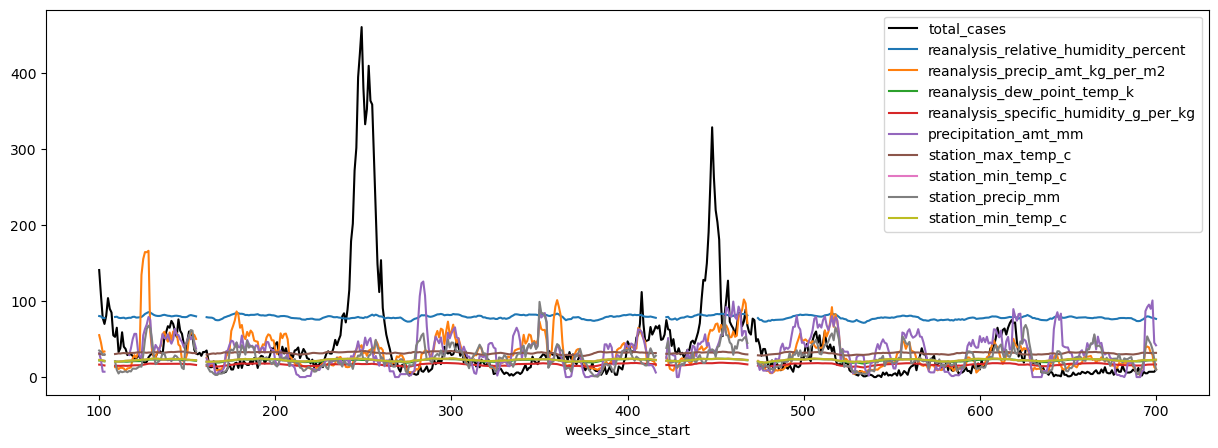

In [19]:
start_week=100
end_week=700

# Try some smoothed variables
features_to_plot=['reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'precipitation_amt_mm', 
                  'station_max_temp_c', 
                  'station_min_temp_c',
                  'station_precip_mm',
                 'station_min_temp_c']
ax=dengue_labels_sj_train.loc[start_week:end_week,['total_cases']].plot(color='black',figsize=(15,5))
for feature in features_to_plot:
    smoothed_feature = dengue_features_sj_train[feature].rolling(window=5,center=False).mean()
    if 'temp_k' in feature:
        # shifting to Celsius
        smoothed_feature = smoothed_feature - 273.15
    smoothed_feature.loc[start_week:end_week].plot(ax=ax,label=feature)
ax.legend()

plt.savefig('test_feature_smooth_cmp_sj.png')

In [20]:
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


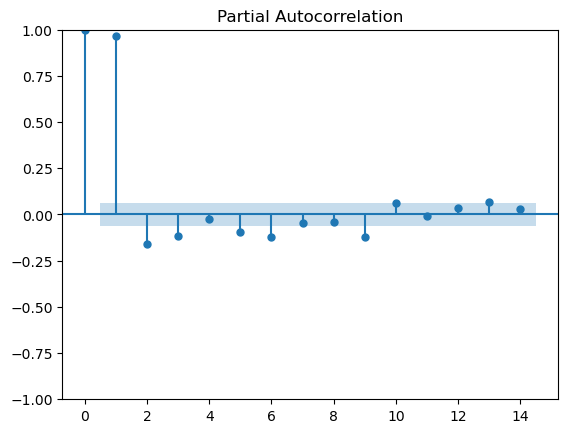

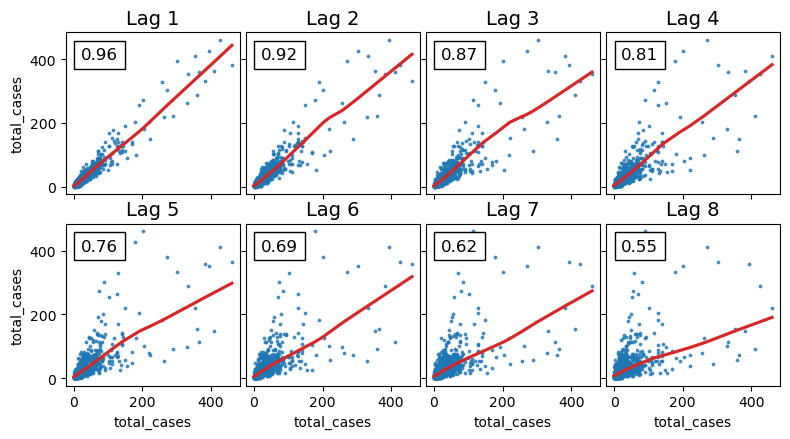

In [21]:
plot_pacf(dengue_labels_sj_train['total_cases'], lags=14);
plt.savefig('pacf.png')
plot_lags(dengue_labels_sj_train['total_cases'], lags=8, nrows=2);

Strong correlation with previous week's cases. No further dependence? Additional partial anticorrelation around -0.15 for week-3?

# Section: Studying Variables

In [22]:
y_sj=dengue_labels_sj_train['total_cases']

In [23]:
# for dataframe X, plot scatter between var 1 and var2
def plot_scatter_corr(X,var1,var2):
        ax=sns.scatterplot(x=X[var1],y=X[var2])
        return ax

Comparing the different precipitation measurements

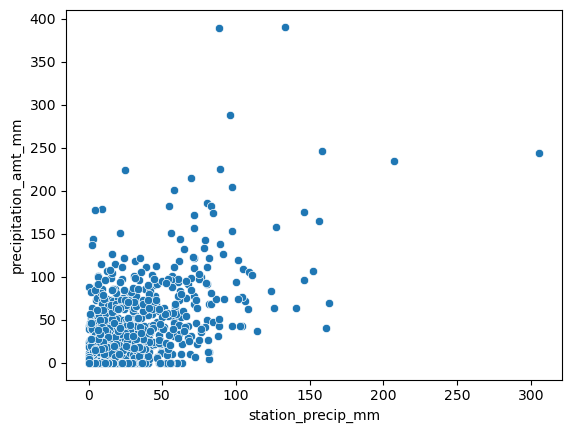

In [24]:
ax=plot_scatter_corr(dengue_features_sj_train,'station_precip_mm','precipitation_amt_mm')

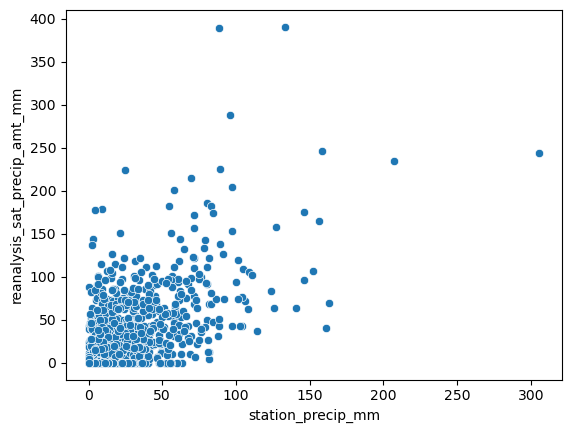

In [25]:
ax=plot_scatter_corr(dengue_features_sj_train,'station_precip_mm','reanalysis_sat_precip_amt_mm')

precipitation_amt_mm and reanalysis_sat_precip_amt_mm are the same

In [26]:
precip_variable='reanalysis_sat_precip_amt_mm'

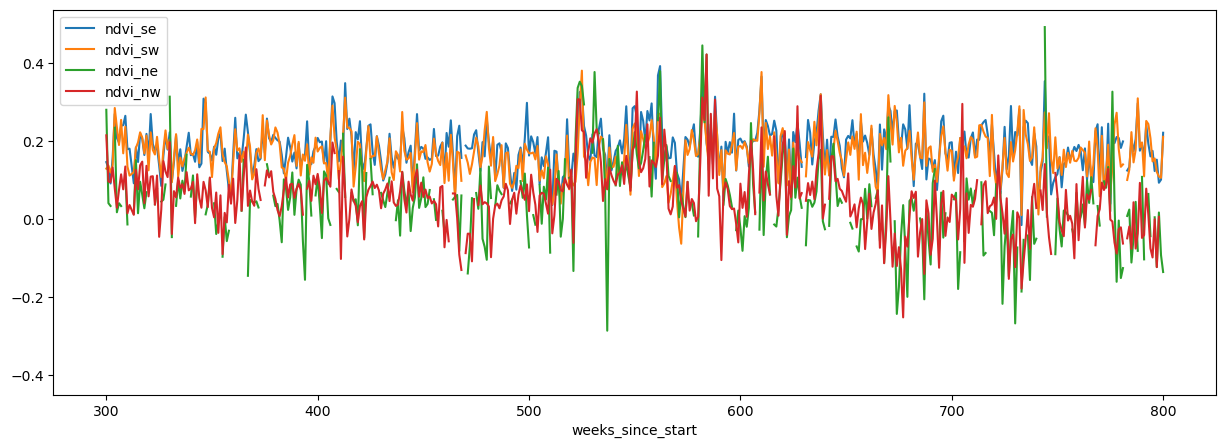

In [27]:
ndvi_features=['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']

start_week=300
end_week=800

ax=dengue_features_sj_train.loc[start_week:end_week,['ndvi_se']].plot(figsize=(15,5))
dengue_features_sj_train.loc[start_week:end_week,['ndvi_sw']].plot(ax=ax)
dengue_features_sj_train.loc[start_week:end_week,['ndvi_ne']].plot(ax=ax)
dengue_features_sj_train.loc[start_week:end_week,['ndvi_nw']].plot(ax=ax)
plt.savefig('ndvi_trends_sj.png')

Could define mean of these.

In [28]:
dengue_features_sj_train_ndvi_mean=dengue_features_sj_train[ndvi_features].mean(axis=1)

In [29]:
dengue_features_sj_train['ndvi_mean']=dengue_features_sj_train_ndvi_mean

<AxesSubplot:ylabel='total_cases'>

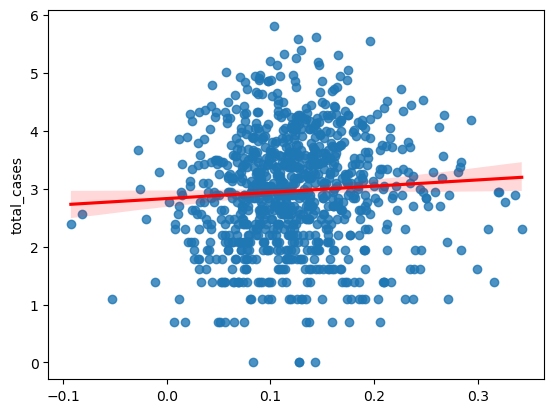

In [30]:
# log transform mainy for convenience
sns.regplot(x=dengue_features_sj_train_ndvi_mean,y=np.log(1+dengue_labels_sj_train['total_cases']),line_kws = {'color': 'red'})

# Section: Variable Correlations

* 1. Look at correlations with given variables.

In [31]:
features_to_ignore=['city','year','weekofyear','week_start_date']
all_features_to_study=[]
for col in dengue_features_sj_train.columns:
    if col not in features_to_ignore:
        all_features_to_study.append(col)
        
print(all_features_to_study)

['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'ndvi_mean']


In [32]:
X_for_mi=dengue_features_sj_train[all_features_to_study].dropna()

(y_for_mi,X_for_mi) = dengue_labels_sj_train['total_cases'].align(X_for_mi, join='inner', axis=0)

In [33]:
X_for_mi.isna().sum(axis=0)

ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
ndvi_mean                                0
dtype: int64

In [34]:
print(X_for_mi.shape)
print(y_for_mi.shape)

(727, 21)
(727,)


In [35]:
# Trying the mutual information code

mi_scores = make_mi_scores(X_for_mi, y_for_mi, 'auto')

In [36]:
# Printing Mutual Information for raw variables with total_cases
print(mi_scores)

station_min_temp_c                       0.103815
reanalysis_max_air_temp_k                0.060545
station_max_temp_c                       0.053238
station_diur_temp_rng_c                  0.040210
reanalysis_dew_point_temp_k              0.036581
reanalysis_relative_humidity_percent     0.036168
reanalysis_avg_temp_k                    0.034413
reanalysis_tdtr_k                        0.027695
precipitation_amt_mm                     0.026473
reanalysis_min_air_temp_k                0.023197
reanalysis_specific_humidity_g_per_kg    0.017230
reanalysis_sat_precip_amt_mm             0.016945
reanalysis_air_temp_k                    0.014485
station_avg_temp_c                       0.005320
ndvi_ne                                  0.004657
ndvi_nw                                  0.001087
station_precip_mm                        0.000000
reanalysis_precip_amt_kg_per_m2          0.000000
ndvi_sw                                  0.000000
ndvi_se                                  0.000000


<AxesSubplot:xlabel='station_precip_mm', ylabel='total_cases'>

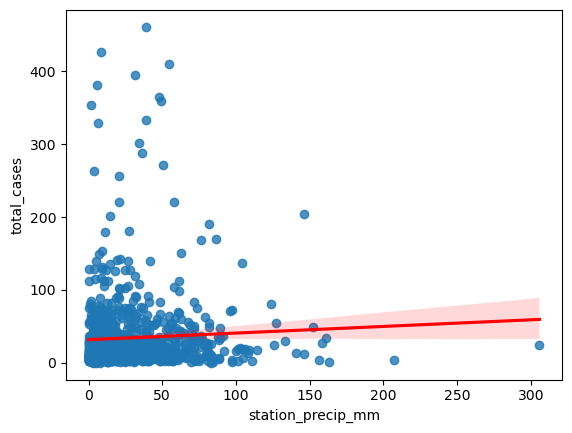

In [37]:
#sns.scatterplot(x=dengue_features_sj_train['station_precip_mm'],y=dengue_labels_sj_train['total_cases'])
sns.regplot(x=dengue_features_sj_train['station_precip_mm'],y=dengue_labels_sj_train['total_cases'],line_kws = {'color': 'red'})

In [38]:
features_to_correlate=[precip_variable,
                       'reanalysis_relative_humidity_percent',
                       'reanalysis_dew_point_temp_k',
                       'reanalysis_avg_temp_k',
                      ]

# sns.scatterplot(x=dengue_features_sj_train['station_precip_mm'],y=dengue_labels_sj_train['total_cases'])

<AxesSubplot:xlabel='reanalysis_avg_temp_k', ylabel='total_cases'>

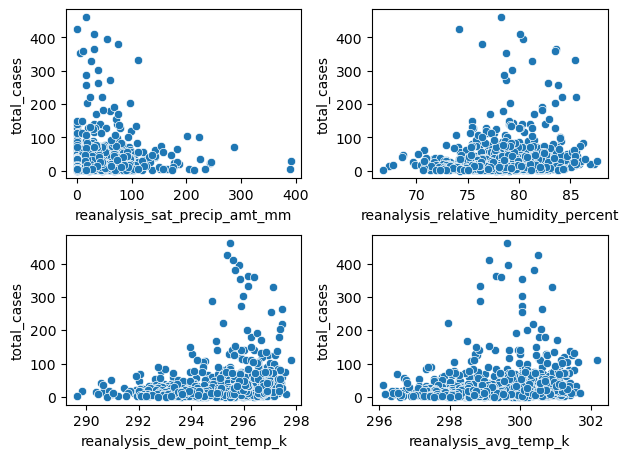

In [39]:

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=2.0)
sns.scatterplot(x=dengue_features_sj_train[features_to_correlate[0]],y=dengue_labels_sj_train['total_cases'],ax=ax1)
sns.scatterplot(x=dengue_features_sj_train[features_to_correlate[1]],y=dengue_labels_sj_train['total_cases'],ax=ax2)
sns.scatterplot(x=dengue_features_sj_train[features_to_correlate[2]],y=dengue_labels_sj_train['total_cases'],ax=ax3)
sns.scatterplot(x=dengue_features_sj_train[features_to_correlate[3]],y=dengue_labels_sj_train['total_cases'],ax=ax4)


Idea: plot vs the derivative of cases. 

# Section: Lagged Variables

In [40]:
y_sj_lags=make_lags(dengue_labels_sj_train['total_cases'],lags=8)

In [41]:
# precip_variable='reanalysis_sat_precip_amt_mm'
precip_variable=precip_variable
ndvi_variable='ndvi_mean'
rel_hum_variable='reanalysis_relative_humidity_percent'
dew_point_variable='reanalysis_dew_point_temp_k'
mean_temp_variable='reanalysis_avg_temp_k'

variables_of_interest=[precip_variable,ndvi_variable,
                       rel_hum_variable,dew_point_variable,
                       mean_temp_variable]
# for labelling
varnames_of_interest=['precip','ndvi','rel_hum','dew_pt','mean_temp']
vartitles_of_interest=['Precipitation','Vegetation Index','Relative Humidity','Dew Point','Mean Temp']

In [42]:
# Try some smoothing of these features
#dengue_features_sj_train[variables_of_interest[i]]
precip_rolling=dengue_features_sj_train[precip_variable].rolling(window=5,center=False).mean()


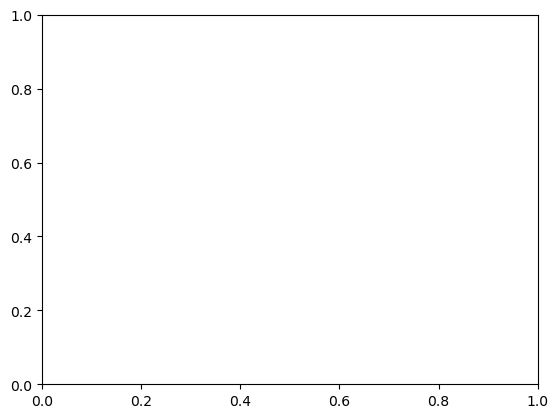

In [43]:
smoothed_features=[]
for i in range(len(variables_of_interest)):
    variable=variables_of_interest[i]
    varname=varnames_of_interest[i]
    vartitle=vartitles_of_interest[i]
    variable_rolling = dengue_features_sj_train[variable].rolling(window=5,center=False).mean()
    smoothed_features.append(variable_rolling)
    ax = dengue_features_sj_train[variable].plot(label=vartitle)
    variable_rolling.plot(ax=ax,label="%s (smoothed)" % (vartitle))
    ax.legend()
    #ax.set_ylabel(vartitle_of_interest[i])
    plt.savefig("variable_%s_smoothed.png" % (varname))
    ax.clear()

In [44]:
# can use code from Time Series course

n_lags=24

lags_list=[]
lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(dengue_features_sj_train[variables_of_interest[i]],
                       lags=n_lags,name=varnames_of_interest[i])
    lags_list.append(var_lags)
    lags_list_no_target.append(var_lags)
    
# add target lags
lags_list.append(y_sj_lags)
    
smoothed_lags_list=[]
smoothed_lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(smoothed_features[i],
                       lags=n_lags,name="%s_smooth" % (varnames_of_interest[i]))
    smoothed_lags_list.append(var_lags)
    smoothed_lags_list_no_target.append(var_lags)


smoothed_lags_list.append(y_sj_lags)
    
#precip_lags=make_lags(dengue_features_sj_train[precip_variable],lags=n_lags,)
#ndvi_lags=make_lags()
# make new data frame before or after lags.
#X_train=dengue_features_sj_train

# Precipitation Lags
precip_lags=lags_list[0]



In [45]:
dengue_features_sj_train_lags=pd.concat(lags_list, axis=1)
dengue_features_no_target_sj_train_lags=pd.concat(lags_list_no_target, axis=1)

dengue_smoothed_features_sj_train_lags=pd.concat(smoothed_lags_list, axis=1)
dengue_smoothed_features_no_target_sj_train_lags=pd.concat(smoothed_lags_list_no_target, axis=1)

In [46]:
print(dengue_features_sj_train_lags.shape)
print(dengue_features_no_target_sj_train_lags.shape)

(936, 128)
(936, 120)


In [47]:
dengue_smoothed_features_sj_train_lags.head(200)

,precip_smooth_lag_1,precip_smooth_lag_2,precip_smooth_lag_3,precip_smooth_lag_4,precip_smooth_lag_5,precip_smooth_lag_6,precip_smooth_lag_7,precip_smooth_lag_8,precip_smooth_lag_9,precip_smooth_lag_10,...,mean_temp_smooth_lag_23,mean_temp_smooth_lag_24,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,12.094,15.058,16.116,14.814,32.126,26.102,23.138,22.080,34.876,16.514,...,299.922857,299.910000,35.0,26.0,31.0,22.0,30.0,38.0,31.0,40.0
213,3.570,12.094,15.058,16.116,14.814,32.126,26.102,23.138,22.080,34.876,...,299.927143,299.922857,36.0,35.0,26.0,31.0,22.0,30.0,38.0,31.0
214,2.520,3.570,12.094,15.058,16.116,14.814,32.126,26.102,23.138,22.080,...,300.081429,299.927143,39.0,36.0,35.0,26.0,31.0,22.0,30.0,38.0


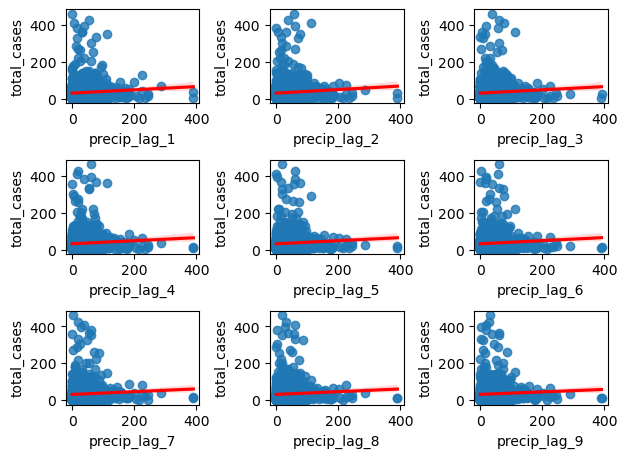

In [48]:
#precip_lags.head()
#print(lags_list)
#for lag_set in lags_list:
#    lag_set.describe()
#precip_lags.plot()

precip_lag_7=precip_lags['precip_lag_7']

#sns.regplot(x=precip_lag_7,y=y_sj)

my_line_kws={'color': 'red'}
# plot first nine lags of precipitation
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
fig.tight_layout(pad=2.0)
sns.regplot(x=precip_lags['precip_lag_1'],y=y_sj,ax=ax1,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_2'],y=y_sj,ax=ax2,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_3'],y=y_sj,ax=ax3,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_4'],y=y_sj,ax=ax4,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_5'],y=y_sj,ax=ax5,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_6'],y=y_sj,ax=ax6,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_7'],y=y_sj,ax=ax7,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_8'],y=y_sj,ax=ax8,line_kws =my_line_kws)
sns.regplot(x=precip_lags['precip_lag_9'],y=y_sj,ax=ax9,line_kws =my_line_kws)
plt.savefig('precip_lag_plots.png')



#sns.regplot(x=dengue_features_sj_train[features_to_correlate[0]],y=deriv_target,ax=ax1,line_kws = my_line_kws)
#sns.regplot(x=dengue_features_sj_train[features_to_correlate[1]],y=deriv_target,ax=ax2,line_kws = my_line_kws)



In [49]:
# Try mutual information on lagged features

# dengue_features_no_target_sj_train_lags
# dengue_features_sj_train_lags
# y_sj


X_lags_no_target_for_mi=dengue_features_no_target_sj_train_lags.dropna()
X_lags_for_mi=dengue_features_sj_train_lags.dropna()
#print(X_lags_no_target_for_mi)

(y_lags_no_target_for_mi,X_lags_no_target_for_mi) = y_sj.align(X_lags_no_target_for_mi, join='inner', axis=0)
(y_lags_for_mi,X_lags_for_mi) = y_sj.align(X_lags_for_mi, join='inner', axis=0)
print(X_lags_no_target_for_mi.shape)
print(y_lags_no_target_for_mi.shape)

mi_scores = make_mi_scores(X_lags_no_target_for_mi, y_lags_no_target_for_mi, 'auto')
mi_with_target_scores = make_mi_scores(X_lags_for_mi, y_lags_for_mi, 'auto')

(675, 120)
(675,)


In [50]:
print(mi_scores.head(24))

dew_pt_lag_8        0.249433
dew_pt_lag_6        0.247949
dew_pt_lag_10       0.237048
dew_pt_lag_11       0.228323
dew_pt_lag_9        0.226345
dew_pt_lag_7        0.221128
mean_temp_lag_10    0.211726
mean_temp_lag_8     0.211618
dew_pt_lag_13       0.208434
mean_temp_lag_9     0.201362
dew_pt_lag_4        0.200983
mean_temp_lag_5     0.197253
mean_temp_lag_7     0.196343
dew_pt_lag_12       0.191191
mean_temp_lag_6     0.177630
mean_temp_lag_12    0.177156
mean_temp_lag_13    0.168799
dew_pt_lag_5        0.162487
dew_pt_lag_3        0.162346
mean_temp_lag_11    0.146235
dew_pt_lag_2        0.144915
mean_temp_lag_4     0.138864
rel_hum_lag_8       0.137842
dew_pt_lag_1        0.136753
Name: MI Scores, dtype: float64


Some of the highest mi scores are from the lagged dew point


In [51]:
print(mi_with_target_scores.head(20))

y_lag_1             1.054199
y_lag_2             0.837762
y_lag_3             0.728400
y_lag_4             0.592481
y_lag_5             0.507928
y_lag_6             0.397498
y_lag_7             0.305007
dew_pt_lag_8        0.253167
y_lag_8             0.252451
dew_pt_lag_6        0.246504
dew_pt_lag_10       0.239075
dew_pt_lag_11       0.234384
mean_temp_lag_10    0.228582
dew_pt_lag_7        0.227854
mean_temp_lag_8     0.216745
dew_pt_lag_9        0.216528
mean_temp_lag_9     0.211952
dew_pt_lag_13       0.204627
mean_temp_lag_7     0.200922
mean_temp_lag_5     0.200681
Name: MI Scores, dtype: float64


After adding in the target lags: the most informative variables are the lagged weekly cases and the dew point. 

# Trying Principal Component Analysis
I'm not sure how useful this would be here. I'm guessing it might have pointed towards using the dew point (a function of humidity, temperature, and pressure)

In [52]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
pca_with_target = PCA()

In [53]:
# Standardizing X data
X_lags_no_target_for_mi_std = (X_lags_no_target_for_mi-X_lags_no_target_for_mi.mean(axis=0))/X_lags_no_target_for_mi.std(axis=0)
X_lags_for_mi_std = (X_lags_for_mi-X_lags_for_mi.mean(axis=0))/X_lags_for_mi.std(axis=0)

In [54]:
X_lags_no_target_pca = pca.fit_transform(X_lags_no_target_for_mi_std)
component_names = [f"PC{i+1}" for i in range(X_lags_no_target_pca.shape[1])]
X_lags_no_target_pca = pd.DataFrame(X_lags_no_target_pca, columns=component_names)

X_lags_no_target_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120
0,-3.198129,-2.795795,6.048375,2.422917,0.127793,2.201196,1.186077,-0.550675,-0.691932,0.002411,...,-0.035841,-0.040103,-0.017882,-0.007789,0.009903,0.025790,-0.056383,-0.001327,-0.018685,-0.009465
1,-3.780194,-1.954469,6.322935,2.089483,-1.060901,2.090749,0.757612,1.614128,-0.685301,-0.132663,...,-0.080281,-0.031885,0.009744,-0.030431,-0.016721,-0.009362,-0.023306,-0.020495,0.026674,0.021775
2,-4.185827,-1.388679,6.491683,1.808338,-2.003814,2.065533,-0.521544,2.615275,0.655723,0.040066,...,-0.068393,0.031414,0.026574,-0.012243,-0.031195,0.013822,0.011960,0.008221,-0.013416,-0.007007
3,-4.370711,-1.213911,6.858495,1.941174,-2.344030,2.078285,-1.009871,0.482429,2.120422,0.388471,...,-0.037501,0.067723,-0.000799,0.017684,0.007564,-0.008912,0.025231,-0.014082,0.013922,-0.000947
4,-4.550125,-0.828705,6.817726,1.751195,-2.844507,1.252862,-0.612475,-2.338728,1.561116,-0.832462,...,0.003432,0.041065,-0.019854,0.045919,0.042348,-0.011503,0.013687,0.016170,0.004675,0.009739


In [55]:
mi_pca_scores = make_mi_scores(X_lags_no_target_pca, y_lags_no_target_for_mi, 'auto')

In [56]:
print(mi_pca_scores.head(20))

PC3      0.291943
PC1      0.207584
PC97     0.181779
PC2      0.178335
PC6      0.111015
PC4      0.102435
PC31     0.095020
PC98     0.091122
PC68     0.060816
PC49     0.053171
PC36     0.052494
PC11     0.050905
PC120    0.048870
PC7      0.047831
PC52     0.046036
PC86     0.045879
PC19     0.045548
PC80     0.043107
PC99     0.042156
PC12     0.041316
Name: MI Scores, dtype: float64


In [57]:
X_lags_pca = pca_with_target.fit_transform(X_lags_for_mi_std)
component_names_with_target = [f"PC{i+1}" for i in range(X_lags_pca.shape[1])]
X_lags_pca = pd.DataFrame(X_lags_pca, columns=component_names_with_target)

print(X_lags_pca.head(20))

mi_pca_scores_with_target = make_mi_scores(X_lags_pca, y_lags_for_mi, 'auto')


         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  -3.247577 -2.671576  5.459614 -2.663531  2.176597  0.253299  2.346079   
1  -3.843655 -1.820198  5.762405 -2.461977  1.881670 -0.918387  2.324352   
2  -4.246669 -1.242467  5.937015 -2.368294  1.622023 -1.875602  2.409124   
3  -4.506332 -1.088266  6.361134 -2.201406  1.782146 -2.182411  2.448285   
4  -4.789177 -0.730456  6.428636 -1.863464  1.625766 -2.699871  1.667554   
5  -4.846818 -0.185740  6.325250 -1.877494  1.679124 -2.845706  0.511320   
6  -4.893774  0.401721  6.416140 -1.756714  1.692849 -2.793163 -0.771024   
7  -4.817508  1.135748  6.547108 -1.777939  1.671153 -2.415224 -1.648438   
8  -4.618058  1.436708  6.742055 -1.754949  1.898239 -1.280245 -1.946852   
9  -4.173994  2.844871  6.776570 -1.829724  2.412722  0.100363 -2.673474   
10 -3.767733  3.385570  7.147906 -1.994775  2.562568  0.973921 -2.531200   
11 -3.081169  4.800791  7.116966 -2.223262  2.950553  2.124953 -2.942449   
12 -2.264656

In [58]:
print(mi_pca_scores_with_target.head(30))

PC4      0.295876
PC3      0.247754
PC1      0.227115
PC105    0.217523
PC2      0.157045
PC5      0.116306
PC104    0.112213
PC7      0.110539
PC6      0.110127
PC106    0.089742
PC101    0.083240
PC41     0.070684
PC102    0.070087
PC100    0.069588
PC37     0.059103
PC12     0.053355
PC48     0.047679
PC8      0.047639
PC39     0.045582
PC51     0.044206
PC85     0.042216
PC82     0.041667
PC112    0.040547
PC128    0.039490
PC126    0.037959
PC109    0.035390
PC110    0.033919
PC107    0.033836
PC108    0.033327
PC95     0.031523
Name: MI Scores, dtype: float64


In [59]:
# more study
loadings_no_target = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_lags_no_target_for_mi_std.columns,  # and the rows are the original features
)

loadings = pd.DataFrame(
    pca_with_target.components_.T,  # transpose the matrix of loadings
    columns=component_names_with_target,  # so the columns are the principal components
    index=X_lags_for_mi_std.columns,  # and the rows are the original features
)
#loadings

# Studying time-derivatives
This, and the correlations with the features, may justify these variables

In [60]:
y_sj_deriv=dengue_labels_sj_train['total_cases']-y_sj_lags['y_lag_1']

<AxesSubplot:xlabel='weeks_since_start'>

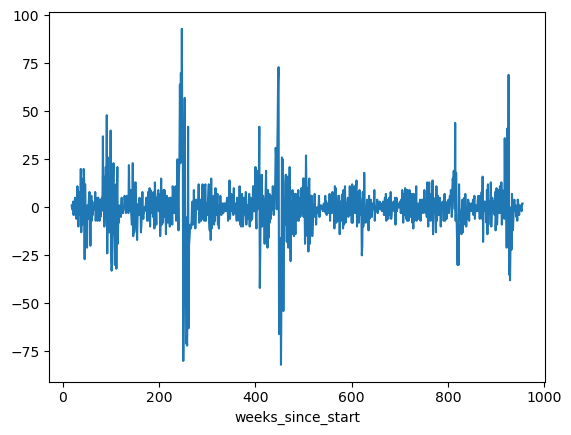

In [61]:
y_sj_deriv.plot()

Can we smooth this out?

In [62]:
y_sj_deriv_smooth_mean=y_sj_deriv.rolling(window=7,center=True,win_type='gaussian').mean(std=3)


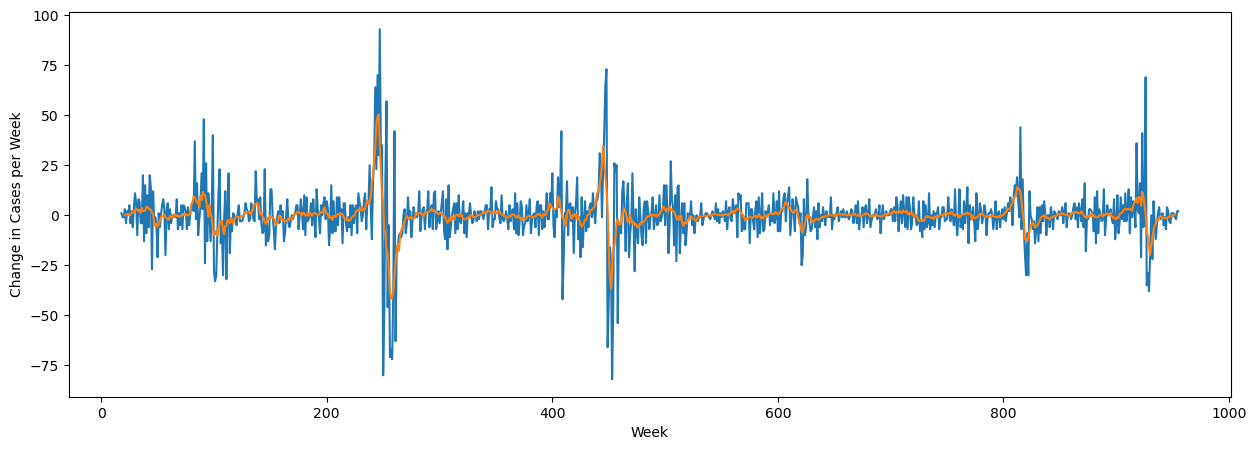

In [63]:
ax=y_sj_deriv.plot(figsize=(15,5))
y_sj_deriv_smooth_mean.plot(ax=ax)
ax.set(xlabel="Week",ylabel="Change in Cases per Week")
plt.savefig("deriv_smoothing.png")

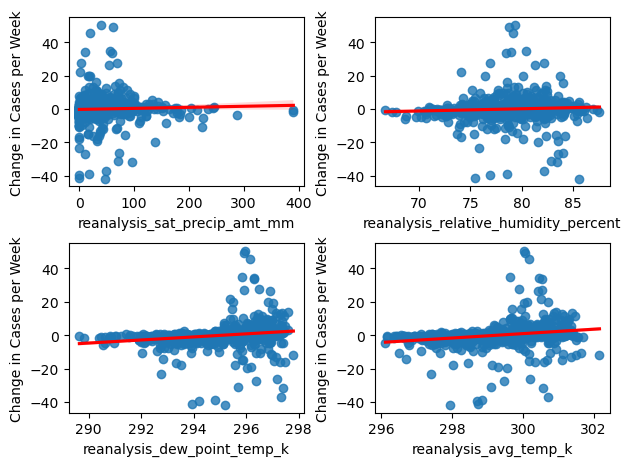

In [64]:
#deriv_target=y_sj_deriv
deriv_target=y_sj_deriv_smooth_mean

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=2.0)
g=sns.regplot(x=dengue_features_sj_train[features_to_correlate[0]],y=deriv_target,ax=ax1,line_kws = {'color': 'red'})
sns.regplot(x=dengue_features_sj_train[features_to_correlate[1]],y=deriv_target,ax=ax2,line_kws = {'color': 'red'})
sns.regplot(x=dengue_features_sj_train[features_to_correlate[2]],y=deriv_target,ax=ax3,line_kws = {'color': 'red'})
sns.regplot(x=dengue_features_sj_train[features_to_correlate[3]],y=deriv_target,ax=ax4,line_kws = {'color': 'red'})

for ax_0 in [ax1,ax2,ax3,ax4]:
    ax_0.set(ylabel="Change in Cases per Week")

plt.savefig("correlations_4.png")

In [65]:
# Could calculate MI for these with respect to the smoothed derivative

<AxesSubplot:xlabel='reanalysis_dew_point_temp_k'>

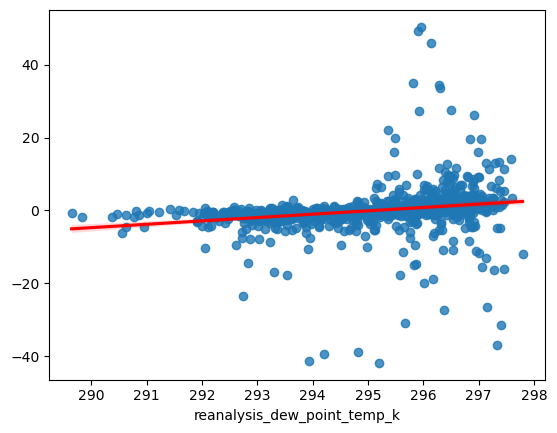

In [66]:
sns.regplot(x=dengue_features_sj_train[features_to_correlate[2]],y=deriv_target,line_kws = {'color': 'red'})

# Defining Training and Target Sets

Do I do the train/valid split before or after building the final frame from the lagged variables?

In [67]:
from sklearn.model_selection import train_test_split

# Making Predictors


Copying some code from the Time Series thing

In [68]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=6, desat=None)
    #palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        #preds.index = pd.period_range(start=date, periods=len(preds))
        preds.index = range(date,date+len(preds))
        preds.plot(ax=ax,label=f"Forecast from {date}")
    return ax

In [69]:
y_sj_multistep = make_multistep_target(y_sj,steps=10).dropna()
y_sj_twostep = make_multistep_target(y_sj,steps=2).dropna()

In [70]:
y_sj_multistep

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
weeks_since_start,,,,,,,,,,
17,4,5.0,4.0,3.0,6.0,2.0,4.0,5.0,10.0,6.0
18,5,4.0,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0
19,4,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0
20,3,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0
21,6,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0,17.0
...,...,...,...,...,...,...,...,...,...,...
942,10,9.0,2.0,6.0,8.0,5.0,1.0,2.0,3.0,4.0
943,9,2.0,6.0,8.0,5.0,1.0,2.0,3.0,4.0,3.0
944,2,6.0,8.0,5.0,1.0,2.0,3.0,4.0,3.0,1.0


In [71]:
dengue_features_sj_train_lags

,precip_lag_1,precip_lag_2,precip_lag_3,precip_lag_4,precip_lag_5,precip_lag_6,precip_lag_7,precip_lag_8,precip_lag_9,precip_lag_10,...,mean_temp_lag_23,mean_temp_lag_24,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,12.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,22.82,12.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
20,34.54,22.82,12.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN
21,15.36,34.54,22.82,12.42,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,81.22,0.00,...,301.635714,300.942857,3.0,2.0,1.0,5.0,8.0,6.0,2.0,9.0
952,27.19,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,81.22,...,301.092857,301.635714,4.0,3.0,2.0,1.0,5.0,8.0,6.0,2.0
953,3.82,27.19,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,299.542857,301.092857,3.0,4.0,3.0,2.0,1.0,5.0,8.0,6.0


In [72]:
# Set 1: including target lags
y = y_sj_multistep
X = dengue_features_sj_train_lags.fillna(0)

y_1, X_1 = y.align(X, join='inner', axis=0)

# Set2: target lags not includes
X_2=dengue_features_no_target_sj_train_lags.fillna(0)
y_2, X_2 = y.align(X_2, join='inner', axis=0)

X_3=dengue_smoothed_features_sj_train_lags.fillna(0)
y_3, X_3 = y.align(X_3, join='inner', axis=0)

X_4=dengue_smoothed_features_no_target_sj_train_lags.fillna(0)
y_4, X_4 = y.align(X_4, join='inner', axis=0)

# no multisteping for forecast. intended for recursive regressive
X_5=dengue_features_no_target_sj_train_lags.fillna(0)
y_5, X_5 = y_sj_twostep.align(X_5, join='inner', axis=0)


In [73]:
print(type(dengue_features_sj_train_lags))
print(dengue_features_sj_train_lags.shape)

<class 'pandas.core.frame.DataFrame'>
(936, 128)


In [74]:
test_size=400

X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size=test_size, shuffle=False)
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(X_2, y_2, test_size=test_size, shuffle=False)

X_3_train, X_3_valid, y_3_train, y_3_valid = train_test_split(X_3, y_3, test_size=test_size, shuffle=False)
X_4_train, X_4_valid, y_4_train, y_4_valid = train_test_split(X_4, y_4, test_size=test_size, shuffle=False)

X_5_train, X_5_valid, y_5_train, y_5_valid = train_test_split(X_5, y_5, test_size=test_size, shuffle=False)

print(X_train.shape)
print(X_valid.shape)

(527, 128)
(400, 128)


In [75]:

#test_size=400
X_6 = dengue_features_sj_train_lags.dropna()
y_6, X_6 = y.align(X_6, join='inner', axis=0)
X_7 = dengue_features_no_target_sj_train_lags.dropna()
y_7, X_7 = y.align(X_7, join='inner', axis=0)
# Split before standardizing. Standardize with training set
# also do PCA with training set
X_6_train, X_6_valid, y_6_train, y_6_valid = train_test_split(X_6, y_6, test_size=test_size, shuffle=False)
X_7_train, X_7_valid, y_7_train, y_7_valid = train_test_split(X_7, y_7, test_size=test_size, shuffle=False)

# Standardize training X
X_6_train_standard = (X_6_train - X_6_train.mean(axis=0))/X_6_train.std(axis=0)
X_7_train_standard = (X_7_train - X_7_train.mean(axis=0))/X_7_train.std(axis=0)

# Standardize validation X using training X mean, std
X_6_valid_standard = (X_6_valid - X_6_train.mean(axis=0))/X_6_train.std(axis=0)
X_7_valid_standard = (X_7_valid - X_7_train.mean(axis=0))/X_7_train.std(axis=0)

# Maybe dropna just for PCA?

In [76]:
pca_6 = PCA()
pca_7 = PCA()

X_6_train_PCA = pca_6.fit_transform(X_6_train_standard)
component_names = [f"PC{i+1}" for i in range(X_6_train_standard.shape[1])]
X_6_train_PCA = pd.DataFrame(X_6_train_PCA, columns=component_names)

X_6_valid_PCA = pca_6.transform(X_6_valid_standard)
X_6_valid_PCA = pd.DataFrame(X_6_valid_PCA, columns=component_names)

X_7_train_PCA = pca_7.fit_transform(X_7_train_standard)
component_names = [f"PC{i+1}" for i in range(X_7_train_standard.shape[1])]
X_7_train_PCA = pd.DataFrame(X_7_train_PCA, columns=component_names)

X_7_valid_PCA = pca_7.transform(X_7_valid_standard)
X_7_valid_PCA = pd.DataFrame(X_7_valid_PCA, columns=component_names)

# May want to drop all but the first M features


In [77]:
num_PCs_to_use_6 = 5
num_PCs_to_use_7 = 5

list_of_PCs=[]
for i in range(num_PCs_to_use_6):
    list_of_PCs.append(f"PC{i+1}")

X_6_train_PCA_simple=X_6_train_PCA[list_of_PCs]
print(X_6_train_PCA_simple.head())
X_6_valid_PCA_simple=X_6_valid_PCA[list_of_PCs]

list_of_PCs=[]
for i in range(num_PCs_to_use_7):
    list_of_PCs.append(f"PC{i+1}")

X_7_train_PCA_simple=X_7_train_PCA[list_of_PCs]
print(X_7_train_PCA_simple.head())
X_7_valid_PCA_simple=X_7_valid_PCA[list_of_PCs]

        PC1       PC2       PC3       PC4       PC5
0 -4.071610 -2.496342  5.387651 -0.772974 -0.034332
1 -4.812318 -1.800676  5.455527 -1.044900  0.619892
2 -5.287638 -1.333005  5.459160 -1.465561  1.351216
3 -5.617771 -1.105775  5.890566 -1.245565  2.134254
4 -5.996258 -0.711091  5.677056 -0.918782  3.079628
        PC1       PC2       PC3       PC4       PC5
0 -4.419947 -2.424870  5.247815  0.050081  1.754126
1 -5.124176 -1.717538  5.295428  0.777066  1.883492
2 -5.588463 -1.241576  5.260908  1.624922  2.438892
3 -5.833476 -1.003446  5.722845  2.429220  2.967082
4 -6.066557 -0.604510  5.553074  3.322286  1.892320



# Defining Models

In [78]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

In [79]:
n_estimators=30
n_jobs=4

early_stopping_rounds=None

## XBGRegressor, a boosted decision tree regressor
model_1 = RegressorChain(XGBRegressor(n_estimators=n_estimators, n_jobs=n_jobs))
#                                            early_stopping_rounds=early_stopping_rounds,
#                                            eval_set=[(X_valid, y_valid)]))

#model_1 = MultiOutputRegressor(XGBRegressor(n_estimators=n_estimators, n_jobs=n_jobs,early_stopping_rounds=5))

## model for data without target lags
model_2 = RegressorChain(XGBRegressor(n_estimators=n_estimators))
#                                            n_jobs=n_jobs,early_stopping_rounds=early_stopping_rounds,
#                                            eval_set=[(X_2_valid, y_2_valid)]))

## models 3 and 4 will use smoothed inputs
model_3 = RegressorChain(XGBRegressor(n_estimators=n_estimators))
#                                            n_jobs=n_jobs,early_stopping_rounds=early_stopping_rounds,
#                                            eval_set=[(X_3_valid, y_3_valid)]))
model_4 = RegressorChain(XGBRegressor(n_estimators=n_estimators))
#                                            n_jobs=n_jobs,early_stopping_rounds=early_stopping_rounds,
#                                            eval_set=[(X_4_valid, y_4_valid)]))
# Model 5: Regressor, but only forecasting 2 steps
model_5 = RegressorChain(XGBRegressor(n_estimators=100, learning_rate=0.05))
#                                    n_jobs=4,early_stopping_rounds=early_stopping_rounds,
#                                    eval_set=[(X_2_valid, y_2_valid)]))
# Regressor Chain
#RegressorChain
#model_1 = RegressorChain(XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4))

# model for data without target lags
#model_2 = RegressorChain(XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4))

# models 3 and 4 will use smoothed inputs
#model_3 = RegressorChain(XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4))
#model_4 = RegressorChain(XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4))


# Test: replace XGBRegressor() with linear regressor.
# expect overfitting, lack of generalization
#model_1 = MultiOutputRegressor(LinearRegression())
#model_2 = MultiOutputRegressor(LinearRegression())
#model_3 = MultiOutputRegressor(LinearRegression())
#model_4 = MultiOutputRegressor(LinearRegression())


I may need to be careful with the regressor chains with the standardized and transformed models, as the regressor chain (I assume) doesn't standardize the predictions that get passed into back into the model. Then again, I never worried about that before.

In [80]:
## Models 6 and 7 use data that has been standardized and transformed according to 
## a principal component analysis
## Note: the inputs for the predictions will also need to be standardized and transformed
##   using the information (feature mean, feature std, and pca matrix) from the training data
## Model for data with target lags

# more options: LinearRegression, Ridge, Lasso


#model_6 = RegressorChain(XGBRegressor(n_estimators=n_estimators, n_jobs=n_jobs))
model_6 = MultiOutputRegressor(XGBRegressor(n_estimators=n_estimators, n_jobs=n_jobs))
#model_6 = LinearRegression()
#model_6 = Lasso(alpha=1.0)

## model for data without target lags
#model_7 = RegressorChain(XGBRegressor(n_estimators=n_estimators))
model_7 = MultiOutputRegressor(XGBRegressor(n_estimators=n_estimators))
#model_7 = LinearRegression()
#model_7 = Lasso(alpha = 1.0)

# Fitting Models

In [81]:
# Fit Model 1
model = model_1

#model.fit(X_train, y_train)
model.fit(X_train, y_train)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                   

In [82]:
model_2.fit(X_2_train,y_2_train)
# fit models 3 and 4
model_3.fit(X_3_train,y_3_train)
model_4.fit(X_4_train,y_4_train)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                   

In [83]:
print(X_5_train.shape)
print(y_5_train.shape)

(535, 120)
(535, 2)


In [84]:
model_5.fit(X_5_train,y_5_train)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.05, max_bin=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                   

In [85]:
print(X_6_train_PCA_simple.head())
print(X_7_train_PCA_simple.head())

        PC1       PC2       PC3       PC4       PC5
0 -4.071610 -2.496342  5.387651 -0.772974 -0.034332
1 -4.812318 -1.800676  5.455527 -1.044900  0.619892
2 -5.287638 -1.333005  5.459160 -1.465561  1.351216
3 -5.617771 -1.105775  5.890566 -1.245565  2.134254
4 -5.996258 -0.711091  5.677056 -0.918782  3.079628
        PC1       PC2       PC3       PC4       PC5
0 -4.419947 -2.424870  5.247815  0.050081  1.754126
1 -5.124176 -1.717538  5.295428  0.777066  1.883492
2 -5.588463 -1.241576  5.260908  1.624922  2.438892
3 -5.833476 -1.003446  5.722845  2.429220  2.967082
4 -6.066557 -0.604510  5.553074  3.322286  1.892320


In [86]:
model_6.fit(X_6_train_PCA_simple,y_6_train)
model_7.fit(X_7_train_PCA_simple,y_7_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
     

In [87]:
y_pred_train = pd.DataFrame(model.predict(X_train),index=y_train.index,
                            columns=y_train.columns,).clip(0.0)

y_pred_valid = pd.DataFrame(model.predict(X_valid),index=y_valid.index,
                            columns=y_valid.columns,).clip(0.0)

y_2_pred_train = pd.DataFrame(model_2.predict(X_2_train),index=y_2_train.index,
                              columns=y_2_train.columns,).clip(0.0)

y_2_pred_valid = pd.DataFrame(model_2.predict(X_2_valid),index=y_2_valid.index,
                              columns=y_2_valid.columns,).clip(0.0)

y_3_pred_train = pd.DataFrame(model_3.predict(X_3_train),index=y_3_train.index,
                              columns=y_3_train.columns,).clip(0.0)
y_3_pred_valid = pd.DataFrame(model_3.predict(X_3_valid),index=y_3_valid.index,
                              columns=y_3_valid.columns,).clip(0.0)

y_4_pred_train = pd.DataFrame(model_4.predict(X_4_train),index=y_4_train.index,
                              columns=y_4_train.columns,).clip(0.0)
y_4_pred_valid = pd.DataFrame(model_4.predict(X_4_valid),index=y_4_valid.index,
                              columns=y_4_valid.columns,).clip(0.0)

In [88]:
y_5_pred_train = pd.DataFrame(model_5.predict(X_5_train),index=y_5_train.index,
                              columns=y_5_train.columns,).clip(0.0)
y_5_pred_valid = pd.DataFrame(model_5.predict(X_5_valid),index=y_5_valid.index,
                              columns=y_5_valid.columns,).clip(0.0)

In [89]:
y_6_pred_train = pd.DataFrame(model_6.predict(X_6_train_PCA_simple),index=y_6_train.index,
                              columns=y_6_train.columns).clip(0.0)
y_6_pred_valid = pd.DataFrame(model_6.predict(X_6_valid_PCA_simple),index=y_6_valid.index,
                              columns=y_6_valid.columns).clip(0.0)

y_7_pred_train = pd.DataFrame(model_7.predict(X_7_train_PCA_simple),index=y_7_train.index,
                              columns=y_7_train.columns).clip(0.0)
y_7_pred_valid = pd.DataFrame(model_7.predict(X_7_valid_PCA_simple),index=y_7_valid.index,
                              columns=y_7_valid.columns).clip(0.0)

# Studying Model Results

In [90]:
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
print('Model One:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

train_rmse = mean_squared_error(y_2_train, y_2_pred_train, squared=False)
test_rmse = mean_squared_error(y_2_valid, y_2_pred_valid, squared=False)
print('Model Two:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

train_rmse = mean_squared_error(y_3_train, y_3_pred_train, squared=False)
test_rmse = mean_squared_error(y_3_valid, y_3_pred_valid, squared=False)
print('Model Three:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

train_rmse = mean_squared_error(y_4_train, y_4_pred_train, squared=False)
test_rmse = mean_squared_error(y_4_valid, y_4_pred_valid, squared=False)
print('Model Four:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

train_rmse = mean_squared_error(y_5_train, y_5_pred_train, squared=False)
test_rmse = mean_squared_error(y_5_valid, y_5_pred_valid, squared=False)
print('Model Five:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

train_rmse = mean_squared_error(y_6_train, y_6_pred_train, squared=False)
test_rmse = mean_squared_error(y_6_valid, y_6_pred_valid, squared=False)
print('Model Six:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

train_rmse = mean_squared_error(y_7_train, y_7_pred_train, squared=False)
test_rmse = mean_squared_error(y_7_valid, y_7_pred_valid, squared=False)
print('Model Seven:')
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print('')

Model One:
Train RMSE: 5.11
Test RMSE: 20.06

Model Two:
Train RMSE: 5.97
Test RMSE: 73.76

Model Three:
Train RMSE: 5.21
Test RMSE: 19.32

Model Four:
Train RMSE: 6.69
Test RMSE: 76.15

Model Five:
Train RMSE: 6.99
Test RMSE: 68.58

Model Six:
Train RMSE: 1.49
Test RMSE: 42.36

Model Seven:
Train RMSE: 1.33
Test RMSE: 59.81



In [91]:
# Could Get RSquare with this score(X, y, sample_weight=None), i think
#print(model_1.score(X_train,y_train))
r_square=model_1.score(X_valid,y_valid)
print(f"Model 1 Train R^2: {r_square:.2f}\n")
r_square=model_2.score(X_2_valid,y_2_valid)
print(f"Model 2 Train R^2: {r_square:.2f}\n")
r_square=model_3.score(X_3_valid,y_3_valid)
print(f"Model 3 Train R^2: {r_square:.2f}\n")
r_square=model_4.score(X_4_valid,y_4_valid)
print(f"Model 4 Train R^2: {r_square:.2f}\n")
r_square=model_5.score(X_5_valid,y_5_valid)
print(f"Model 5 Train R^2: {r_square:.2f}\n")

r_square=model_6.score(X_6_valid_PCA_simple,y_6_valid)
print(f"Model 6 Train R^2: {r_square:.2f}\n")
r_square=model_7.score(X_7_valid_PCA_simple,y_7_valid)
print(f"Model 7 Train R^2: {r_square:.2f}\n")


Model 1 Train R^2: 0.30

Model 2 Train R^2: -8.12

Model 3 Train R^2: 0.35

Model 4 Train R^2: -8.78

Model 5 Train R^2: -6.87

Model 6 Train R^2: -1.48

Model 7 Train R^2: -3.70



Some of the best recent results:
Model 1 Train R^2: 0.27

Model 2 Train R^2: -8.12

Model 3 Train R^2: 0.41

Model 4 Train R^2: -8.78

Model 5 Train R^2: -6.87

Model 6 Train R^2: -1.19

Model 7 Train R^2: -3.70

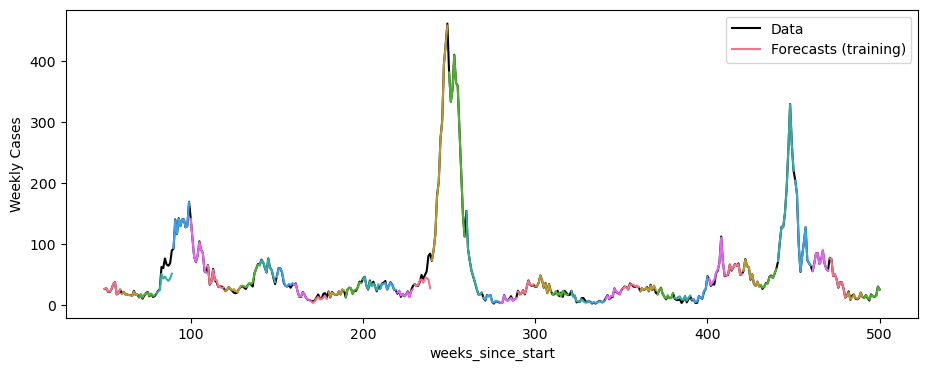

In [92]:
EVERY = 10

START=50
END=500

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_pred_train.loc[START:END],ax=ax,every=EVERY)
ax.set_ylabel('Weekly Cases')
ax.legend(['Data','Forecasts (training)'])
plt.savefig('model_1.png')

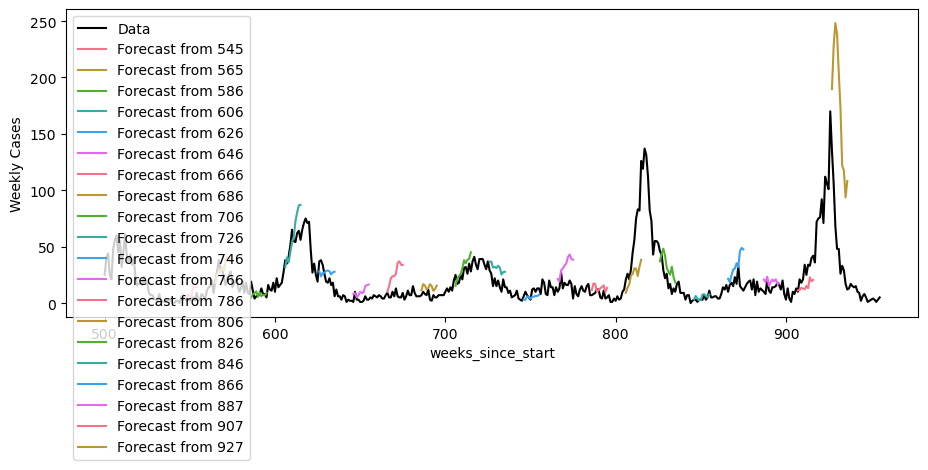

In [93]:
EVERY = 20

START=500
END=1100

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_pred_valid.loc[START:END],ax=ax,every=EVERY)
#x.set_label('test')
ax.legend()
ax.set_ylabel('Weekly Cases')

plt.savefig('model_1_valid.png')


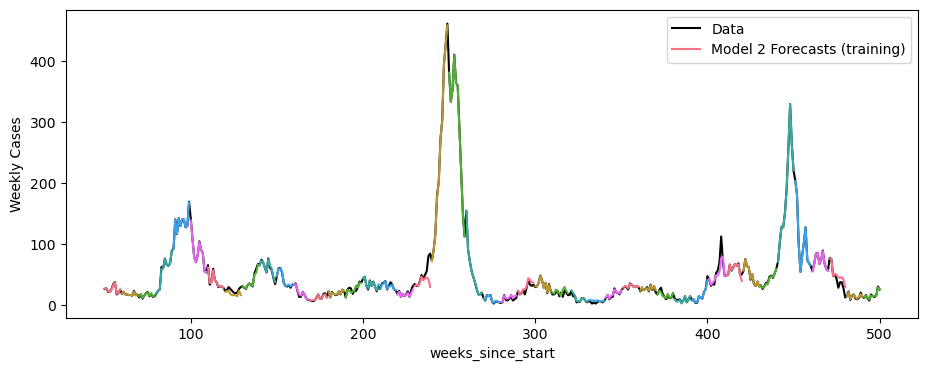

In [94]:
# Examining Model 2 (no target lag information)

EVERY = 10

START=50
END=500

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_2_pred_train.loc[START:END],ax=ax,every=EVERY)
ax.set_ylabel('Weekly Cases')
#ax.legend()
ax.legend(['Data','Model 2 Forecasts (training)'])
plt.savefig('model_2.png')

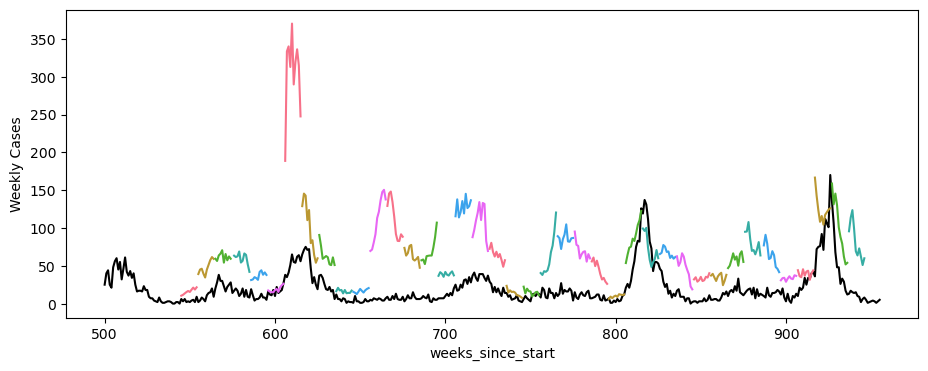

In [95]:
EVERY = 10

START=500
END=1100

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_2_pred_valid.loc[START:END],ax=ax,every=EVERY)
#x.set_label('test')
#x.legend()
ax.set_ylabel('Weekly Cases')

plt.savefig('model_2_valid.png')

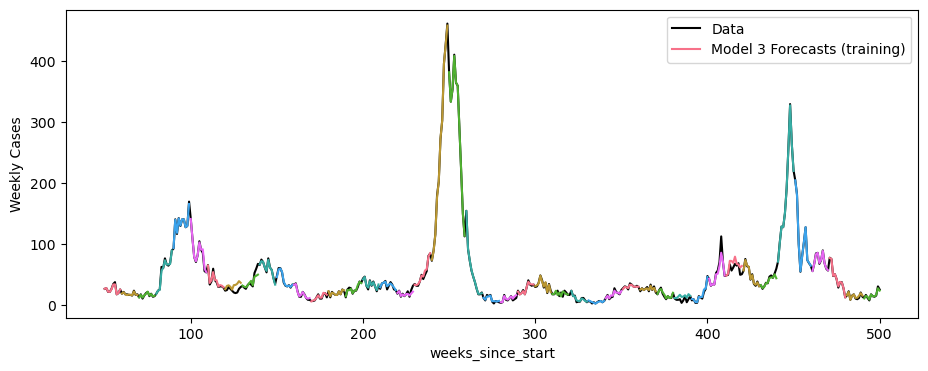

In [96]:
# Examining Model 3 (smoothed inputs)

EVERY = 10

START=50
END=500

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_3_pred_train.loc[START:END],ax=ax,every=EVERY)
ax.set_ylabel('Weekly Cases')
#ax.legend()
ax.legend(['Data','Model 3 Forecasts (training)'])
plt.savefig('model_3.png')

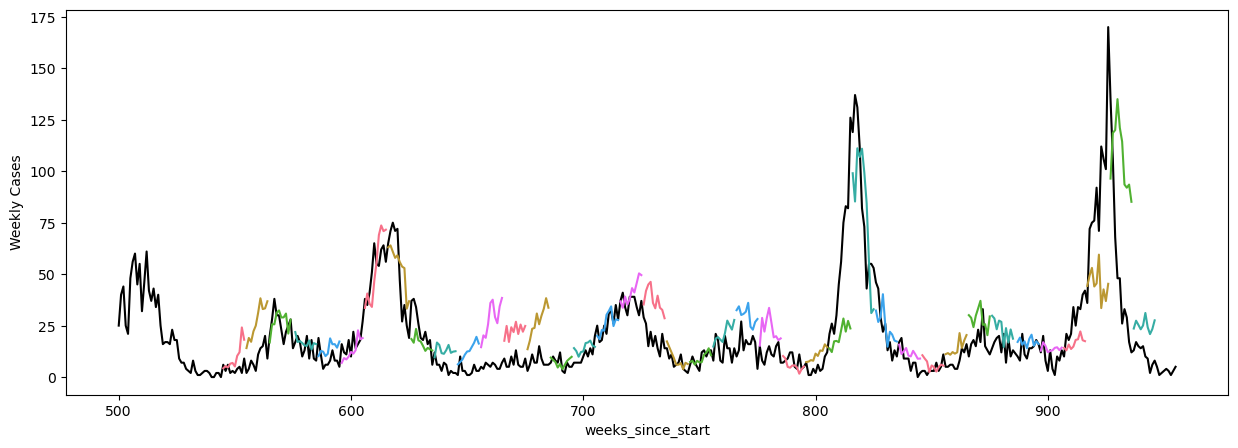

In [97]:
EVERY = 10

START=500
END=1100

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_3_pred_valid.loc[START:END],ax=ax,every=EVERY)
#x.set_label('test')
#ax.legend()
ax.set_ylabel('Weekly Cases')

plt.savefig('model_3_valid.png')

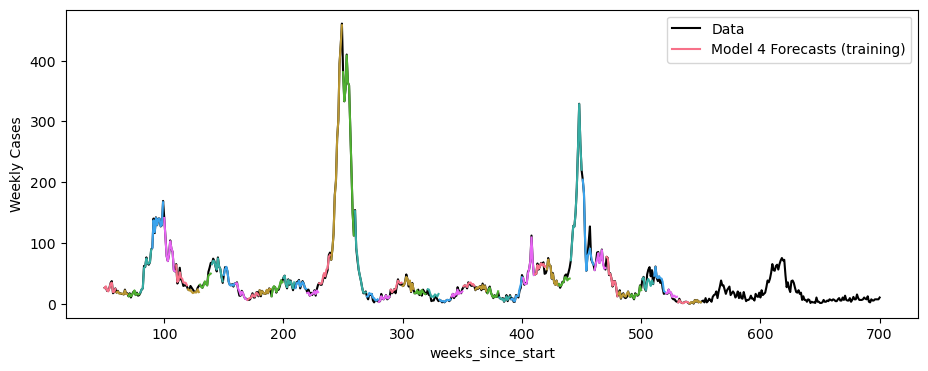

In [98]:
# Examining Model 4 (smoothed inputs, no target info)

EVERY = 10

START=50
END=700

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_4_pred_train.loc[START:END],ax=ax,every=EVERY)
ax.set_ylabel('Weekly Cases')
#ax.legend()
ax.legend(['Data','Model 4 Forecasts (training)'])
plt.savefig('model_4.png')

There is no way it should be getting that peak around 310 without overfitting.

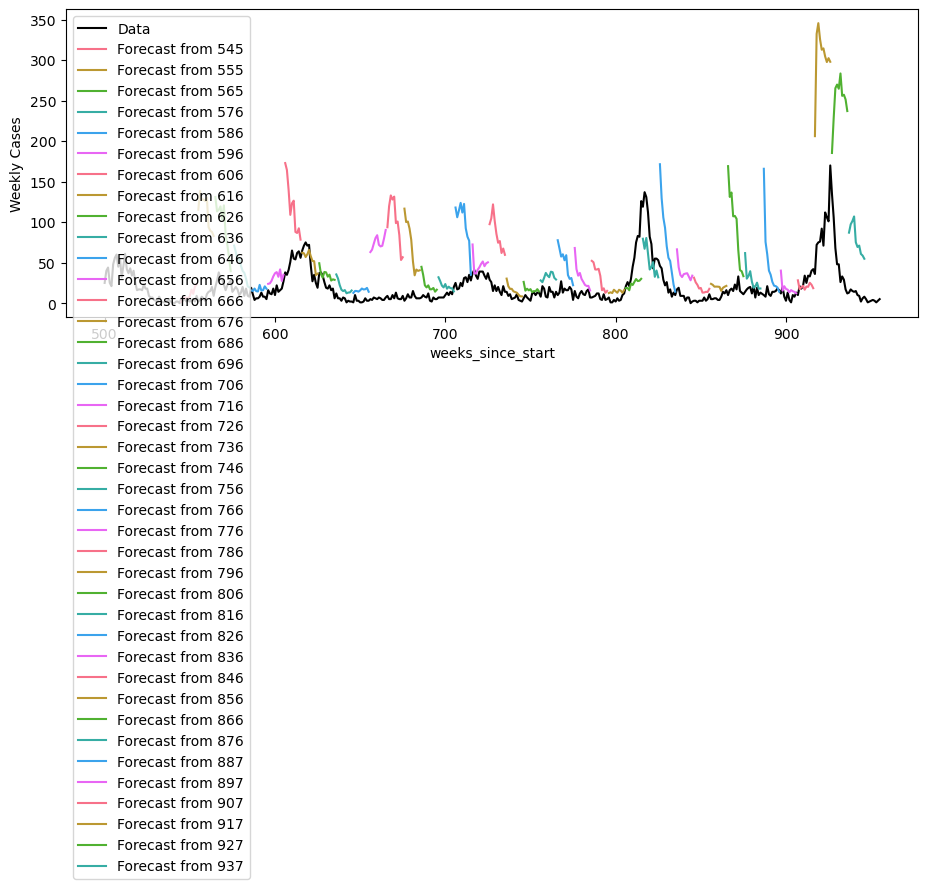

In [99]:
EVERY = 10

START=500
END=1100

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax,label='Data',color='black')

x=plot_multistep(y_4_pred_valid.loc[START:END],ax=ax,every=EVERY)
#x.set_label('test')
ax.legend()
ax.set_ylabel('Weekly Cases')

plt.savefig('model_4_valid.png')

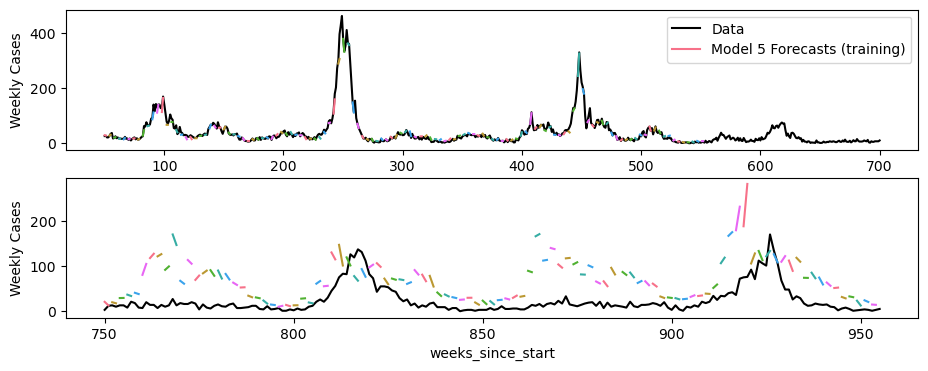

In [100]:
# Examining Model 5 (regressor with two-steps)

EVERY = 4

START=50
END=700

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

x=plot_multistep(y_5_pred_train.loc[START:END],ax=ax1,every=EVERY)
ax1.set_ylabel('Weekly Cases')
#ax.legend()
ax1.legend(['Data','Model 5 Forecasts (training)'])
#plt.savefig('model_4.png')


EVERY = 2

START=750
END=1100

#fig, ax = plt.subplots(1, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

x=plot_multistep(y_5_pred_valid.loc[START:END],ax=ax2,every=EVERY)
#x.set_label('test')
#ax2.legend()
ax2.set_ylabel('Weekly Cases')

plt.savefig('model_5.png')

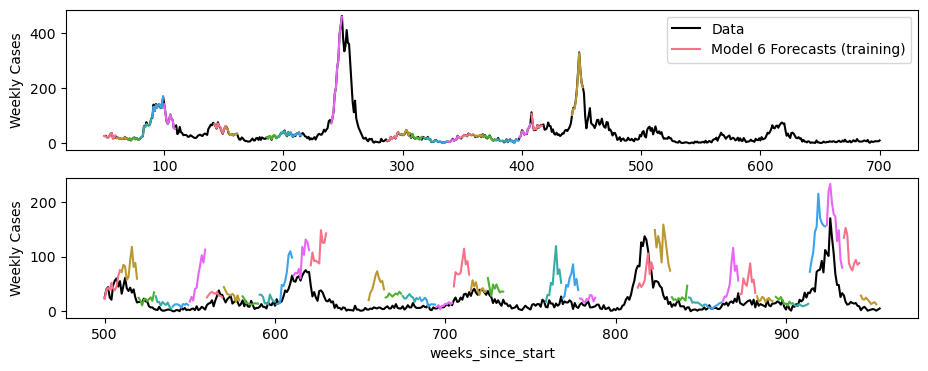

In [101]:
EVERY = 10

START=50
END=700

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

x=plot_multistep(y_6_pred_train.loc[START:END],ax=ax1,every=EVERY)
ax1.set_ylabel('Weekly Cases')
ax1.legend(['Data','Model 6 Forecasts (training)'])


EVERY = 10

START=500
END=1100

line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

x=plot_multistep(y_6_pred_valid.loc[START:END],ax=ax2,every=EVERY)

ax2.set_ylabel('Weekly Cases')

plt.savefig('model_6.png')

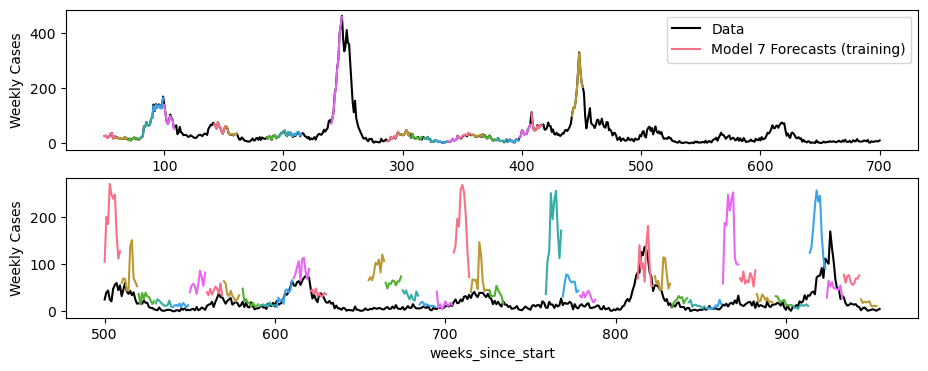

In [102]:
EVERY = 10

START=50
END=700

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(11, 4))
line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

x=plot_multistep(y_7_pred_train.loc[START:END],ax=ax1,every=EVERY)
ax1.set_ylabel('Weekly Cases')
ax1.legend(['Data','Model 7 Forecasts (training)'])


EVERY = 10

START=500
END=1100

line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

x=plot_multistep(y_7_pred_valid.loc[START:END],ax=ax2,every=EVERY)

ax2.set_ylabel('Weekly Cases')

plt.savefig('model_7.png')

Currently, the best models seems to be model 3, which used smoothing of the lagged features, as well as including in the target time-lags. The R^{2} reached 0.4 for one version.

# Next Steps
* Apply smoothing to training target? 
 * Has to be done carefully to avoid data leakage.
* Remove some less important variables (especially ndvi)
 * Plausible that ndvi and other variables could become relevant for including different cities

* Could try modelling a larger set simultaneously, not just the time series forecasts
 
* Study the derivatives some more, especially correlations with positive derivatives.

* Implement neural network models. These may better grab non-linear effects such as the dependence on previous weeks cases, and the effect of the environmental variables on this. Also, the enviromental effects probably have some implicit thresholds, especially the dew point and temperatures
 * Interesting to note that the logistic function, which can describe the total spread of a disease, is also often used as an activation function in neural networks

* Could investigate SIR models of disease spread

Of some relevance, in a simple disease spread model, the total (integrated) infections scale as $\frac{1}{1+e^{x)}$. The weekly rate is the derivative of this, so should resemble:

\begin{equation}
\frac{e^x}{(1+e^{x})^{2}}
\end{equation}

Could consider this information from feature engineering: Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.
Since I'm currently using tree based methods, maybe I should be adding some sums (for precipitation) instead of relying weekly values as separate columns. Although the smoothing with the means essentially does the same thing.